# В файле описана обработка изображений, масок. Разделение на train/validation/test сеты и передача в unet.ipynb для последующего обучения

In [1]:
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd

In [2]:
base_dir = './datasets/oxford-iiit-pet/'
image_dir = os.path.join(base_dir, 'images')
mask_dir = os.path.join(base_dir, 'annotations', 'trimaps')

In [12]:
def load_image(image_path, mask_path, img_size=(128, 128)):
    """
    Функция преобразования как маски, так и изображения.
    
    :param image_path: путь к изображению
    :param mask_path: путь к маске
    :param img_size: размер, к которому преобразуют изображение/маску
    :return img: преобразованное изображение
    :return mask: преобразованная маска
    """
    # Загрузка/преобразование в тензор 3 канала, resize, преобразование пикселей к [0,1]
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    # Загрузка маски с 1 каналом
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    # mask = tf.cast(mask, tf.float32) / 255.0
    mask -= 1

    return img, mask

In [4]:
@tf.function
def random_flip(image, mask):
    """
    Декоратор от tf для ускорения выполнения (компиляции функции в tf граф)
    Функция аугментации с 50% вероятностью переворачивает изображение
    
    :param image: тензор изображения
    :param image: тензор маски
    :return img: преобразованное изображение
    :return mask: преобразованная маска
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask

In [5]:
@tf.function
def random_brightness(image, mask):
    """
    Функция аугментации изменения яркости изображений на 20%
    
    :param image: тензор изображения
    :param image: тензор маски
    :return img: преобразованное изображение
    :return mask: преобразованная маска
    """
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, mask

In [6]:
@tf.function
def random_contrast(image, mask):
     """
    Функция аугментации изменения контраста (самые светлые участки становятся светлее, темные - темнее)
    
    :param image: тензор изображения
    :param image: тензор маски
    :return img: преобразованное изображение
    :return mask: преобразованная маска
    """
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, mask

In [7]:
@tf.function
def augment(image, mask):
     """
    Функция выполнения аугментирующий функций
    
    :param image: тензор изображения
    :param image: тензор маски
    :return img: преобразованное изображение
    :return mask: преобразованная маска
    """
    
    image, mask = random_flip(image, mask)
    image, mask = random_brightness(image, mask)
    image, mask = random_contrast(image, mask)
    return image, mask

In [8]:
def create_dataset(image_dir, mask_dir, img_size=(128, 128)):
    """
    Создает TensorFlow Dataset из директорий с изображениями и масками.
    :param image_dir (str): Путь к директории с исходными изображениями.
    :param mask_dir (str): Путь к директории с масками изображений.
    :param img_size (tuple): Размер, к которому будут приведены изображения и маски. По умолчанию (128, 128).
    
    :return tf.data.Dataset: Dataset, содержащий пары (изображение, маска).
    """
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    df = pd.DataFrame({
        'image_path': [os.path.join(image_dir, f) for f in image_files],
        'mask_path': [os.path.join(mask_dir, f.replace('.jpg', '.png')) for f in image_files]
    })
    # преобразование df в tf dataset
    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['mask_path'].values))
    # изменение параметров изображения и маски
    return dataset.map(lambda x, y: load_image(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
def display(display_list):
    """
    Функция отображения маски и изображения

    :param display_list: датасет с изображениями и масками
    """
    
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

In [10]:
def pipeline_load_images():

    """
    Функция создает и настраивает пайплайн загрузки и обработки изображений для задачи сегментации.

    :return train_batches: tf.data.Dataset для обучения
    :return validation_batches: tf.data.Dataset для валидации
    :return test_batches: tf.data.Dataset для тестирования
    :return steps_per_epoch: количество шагов на эпоху
    :return validation_steps: количество шагов валидации
    """

    # Создание полного датасета
    full_dataset = create_dataset(image_dir, mask_dir)


    # Разделение на train 70% и test 30%
    train_size = int(0.7 * len(os.listdir(image_dir)))
    test_size = len(os.listdir(image_dir)) - train_size

    train_dataset = full_dataset.take(train_size)
    test_dataset = full_dataset.skip(train_size)

    batch_size = 32  # кол-во батчей
    buffer_size = len(train_dataset) // 5  # кол-во элементов в памяти для перемешивания

    # пайплайн для train данных
    train_batches = (train_dataset
                     .map(augment, num_parallel_calls=tf.data.AUTOTUNE)  # аугментация
                     .shuffle(buffer_size)  # перемешивания
                     .batch(batch_size)  # деление на батчи
                     .cache()
                     .repeat()
                     .prefetch(buffer_size=tf.data.AUTOTUNE))  # предзагрузка в фоновом решиме
    # Разделение test на validation и test
    validation_size = int(0.9 * test_size)
    test_size = int(0.1 * test_size)
    
    # пайплайн для validation и test
    validation_batches = test_dataset.take(validation_size).batch(batch_size).cache().repeat()
    test_batches = test_dataset.skip(validation_size).take(test_size).batch(batch_size)

    steps_per_epoch = train_size // batch_size
    validation_steps = test_size // batch_size

    # вывод изображения
    sample_batch = next(iter(train_batches))
    random_index = np.random.choice(sample_batch[0].shape[0])
    sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
    display([sample_image, sample_mask])
    return train_batches, validation_batches, test_batches, steps_per_epoch, validation_steps

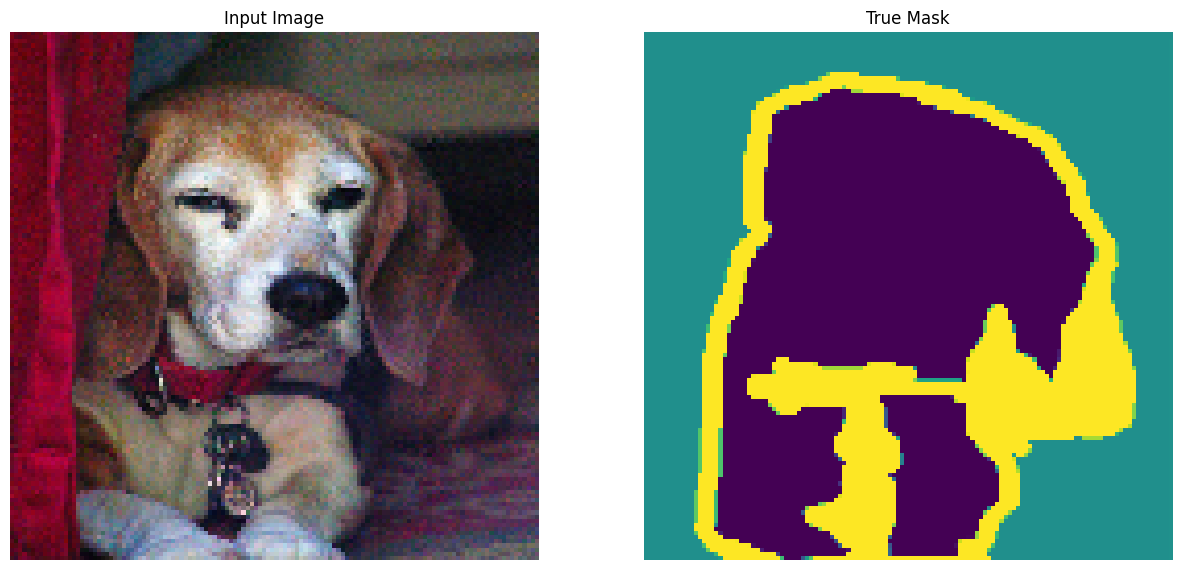

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>,
 <_RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>,
 161,
 6)

In [11]:
pipeline_load_images()